<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\s'
<>:67: SyntaxWarning: invalid escape sequence '\s'
<>:124: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Jacob\AppData\Local\Temp\ipykernel_2036\1878284846.py:67: SyntaxWarning: invalid escape sequence '\s'
  sample = pd.read_csv(filename, sep='\s+', skiprows=skip, engine='python',
C:\Users\Jacob\AppData\Local\Temp\ipykernel_2036\1878284846.py:124: SyntaxWarning: invalid escape sequence '\s'
  corr_og = np.array(pd.read_csv(corr_file, sep='\s+'))


Processing 460-790 CCD_4K_lowenergyrun


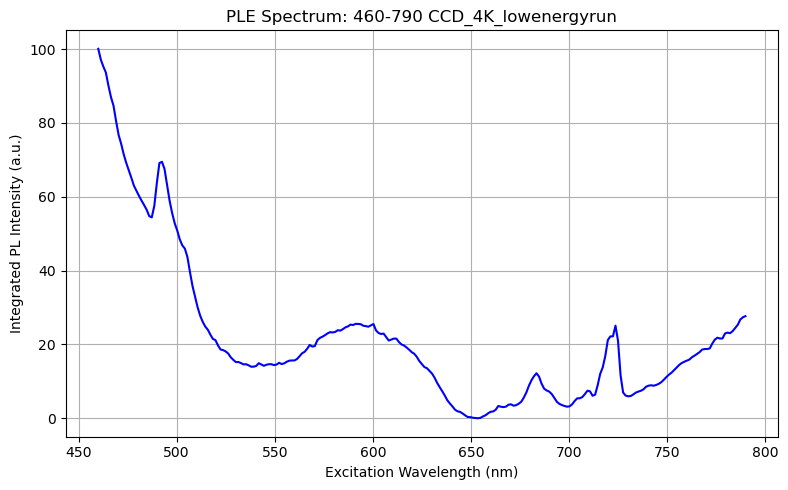

In [8]:
# =============================================================================
# This code will run a single PLE spectrum. For post-data collection workup, please see Lamp PLE all
# Please save each indiviual PLE scan in a folder with the wavelength range of the scan first, e.g. 750-950 4K
# =============================================================================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate

def bulk_import(data_folder):
    '''
    Imports data file names from a folder into python. Then, the full file
    path is made into a list, which is sorted by cycle number (value at the
    end of the file name. For this function to work, the data files should
     have endings like: '_Step000.arc_data'.

    Inputs
        - data_folder: str. path from current directory to the folder where
          the files to be imported are contained.

    Outputs
        - file_list: lst. list of file names (each file name is the path to a
          file in the folder (list of strings)).
    '''

    file_list = []
    for filename in os.listdir(data_folder):
        file_list.append(data_folder + "\\" + filename)

    file_list.sort()

    return file_list


def plefile_import(filename):
    """
    Imports a spectra file from SpectraSense of filetype .arc_data. Converts
    x and y data part of the pandas df. All info in file before and
    after the spectra reading is ignored.

    Inputs
        - filename: str. Path to the file which will be imported. path should
          from the location of this function file to your file.
          ex: './PL/201120/mysample.arc_data'

    Output
        - sample_arr: pd df. An df with 2 columns (wvl, ple) and # of rows
          equal to the number of data points in the file.
    """
    # opens the file and is able to read it
    a_file = open(filename,"r")

    # goes through the file line by line looking for the blank line which is
    # the break between the ccd settings and the data
    for num, line in enumerate(a_file):
        if line.strip() == '':
            # the line number of the blank line is number of rows to skip
            # when reading in the file
            skip=num
        else:
            pass

    # makes file into a workable dataframe with columns 'wvl' and 'pl'
    sample = pd.read_csv(filename, sep='\s+', skiprows=skip, engine='python',
                              names = ['wvl', 'ple'], usecols=[0,1])

    return sample


def ple_bkg_dark(pl_int, file_blank, data_folder_blank=None,
                 dark_file=None):
    '''
    Performs dark spectrum and background (from lamp lines interfering with
    spectra) subtraction if needed. If either modification is not wanted,
    make sure the variable associated (dark_file, data_folder_blank) is None.

    Inputs
        - pl_int: np array. y data of the responding PLE.
        - data_folder_blank: None or str. None if there is no "blank". String
          if there is a blank; path from the current directory to the folder
          containing the blank files
        - file_blank: str. file path in data_folder_blank if a blank folder
          exists.
        - dark_file: None or str. None if there is no dark spectrum file.
          String if there is a dark spectrum file; path from the current
          directory to the dark spectrumfile.

    Outputs
        - pl_int: np array. modified or unmodified y data of the responding
          PLE
    '''
    if dark_file is not None:
        dark_arr = np.array(plefile_import(dark_file))
        pl_int = pl_int - dark_arr[:, 1]

    if data_folder_blank is not None:
        blank_arr = np.array(plefile_import(file_blank))
        pl_int = pl_int - blank_arr[:, 1]

    return pl_int

def ple_correction(corr_file, wvl, type):
    '''
    Performs interpolation on the either the ccd or lamp correction data, so
    it can be used in correcting the specific wvl range of the PL data for
    both the excitation source and the detection source.

    Inputs
        - corr_file: str. path to the ccd correction file.
        - wvl: pd series. x (wavelength) data from your specific PLE. This is
          how the function knows what region to interpolate over. If you have
          put a file into plefile_import, wvl would be file['wvl'].var()
        - type: str. either 'ccd' or 'lamp' (because the lamp file has the
          x and y columns mixed up-who did this??)

    Outputs
        - y_interp: np array. contains the correctly interpolated correction
          y data. to be used in ccd_correction
    '''

    corr_og = np.array(pd.read_csv(corr_file, sep='\s+'))

    if type == 'ccd':
        x_corr = corr_og[:, 0]
        y_corr = corr_og[:, 1]

    elif type == 'lamp':
        x_corr = corr_og[:, 1]
        y_corr = corr_og[:, 0]

    else:
        pass

    f = interpolate.interp1d(x_corr, y_corr, bounds_error=False, fill_value="extrapolate")

    x_interp = np.array(wvl)
    y_interp = f(x_interp)

    return y_interp

def ple_integr(ple_file, pl_l, pl_r, ccd_lamp_corr):
    '''
    Performs PLE integration over specified wavelength range. Returns
    integrated value.

    Inputs
        - ple_file: np array. PLE data from specific file
        - pl_l: int. left_end, left wavelength of PL integration (ex: 585)
        - pl_r: int. right_end, right wavelengt of PL integration (ex: 605)
        - ccd_lamp_corr: np array. ccd and lamp corrected y data of the
          responding PLE.

    Outputs
        - int_ple: flt. integrated intensity over specified wavelength range
          of PL data (y data of PLE).
    '''

    # finding the correct indeces of pl wavelength for integration
    xl = np.argmin(np.abs(ple_file[:, 0]-pl_l))
    xr = np.argmin(np.abs(ple_file[:, 0]-pl_r))

    # perform integration
    int_ple = integrate.simpson(ccd_lamp_corr[xl:xr], x=ple_file[xl:xr, 0])

    return int_ple


import concurrent.futures

def process_ple_file(file, lamp, ccd_interp, pl_l, pl_r,
                     file_blank, data_folder_blank, dark_file):
    try:
        ple_df = plefile_import(file)
        ple_array = ple_df.to_numpy()

        # background and dark subtraction
        ple_corr = ple_bkg_dark(ple_array[:, 1], file_blank, data_folder_blank, dark_file)

        # CCD + lamp correction
        ccd_corr = ple_corr * ccd_interp
        ccd_lamp_corr = ccd_corr * lamp

        # Integrate PLE signal
        int_ple = ple_integr(ple_array, pl_l, pl_r, ccd_lamp_corr)
        return int_ple

    except Exception as e:
        print(f"Error processing {file}: {e}")
        return np.nan


def PLE_calc_parallel(data_folder, ccd_corr_file, lamp_corr_file, exc_st, exc_end,
                      pl_l, pl_r, data_folder_blank=None, dark_file=None):
    file_list = bulk_import(data_folder)
    ple_wavl = plefile_import(file_list[0])['wvl']
    exc_wavl = np.linspace(exc_st, exc_end, len(file_list))

    # Interpolations (done once)
    ccd_interp = ple_correction(ccd_corr_file, ple_wavl, type='ccd')
    lamp_interp = ple_correction(lamp_corr_file, exc_wavl, type='lamp')

    # Handle blank files if given
    file_list_blank = bulk_import(data_folder_blank) if data_folder_blank else [None] * len(file_list)

    # Parallel processing
    int_val = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                process_ple_file, file, lamp, ccd_interp, pl_l, pl_r,
                file_blank, data_folder_blank, dark_file
            )
            for file, lamp, file_blank in zip(file_list, lamp_interp, file_list_blank)
        ]
        for future in concurrent.futures.as_completed(futures):
            int_val.append(future.result())

    # Ensure consistent ordering (zip preserves it, but as_completed does not)
    int_val = [f.result() for f in futures]

    return PLE_df(int_val, exc_wavl)


def PLE_df(int_val, exc_wavl):
    '''
    Makes a dataframe of two columns from data calculated in PLE_calc:
    excitation wavelength and PLE integration. Can be exported to a csv
    using output_PLE_result.

    Inputs
        - int_val: lst. integrated PLE at each exctation wavelength range.
        - exc_wavl: np array: excitation wavelength range.

    Outputs
        - ple_result: pd df. df of excitation wavelength and integrated PLE.
    '''
    # minimum of integrated values to make baseline ~ 0
    int_min = min(int_val)
    # make int_val into a np array so int_min can be subtracted from it
    int_arr = np.array(int_val)

    # make excitation wavelength and int PLE into a dataframe
    ple_result = pd.DataFrame(data={'exc wav': exc_wavl, 'int PLE':
                                    (int_arr-int_min)})

    return ple_result


def output_PLE_result(path, sample_name, temp_folder, ple_result):
    '''
    Exports PLE results into the path:
        sample_name/output/sample_name_temp_folder.csv

    Note: this function will create the folder 'output' if it doesn't already
    exist, so you don't have to.

    Inputs
        - path: str. path from current directory to the PLE data
          ex: "C:/Users/Kelly/Desktop/Documents_2016/Documents/School/UW/Research/PLE/"
        - sample_name: str. Name of the folder containing all the PLE data.
          ex: "210217_20CZnSeCdSeMSC_PLE"
        - temp_folder: str. Name of the folder containing PLE data at a temp
          ex: "5K"
        - ple_result: pd df. df of excitation wavelength and integrated PLE.

    Outputs
        - csv into the output folder
    '''
    outname = sample_name + '_' + temp_folder + '.csv'
    outdir = path + sample_name + '/output/'

    # looks for a folder called output in sample directory. If it doesn't
    # exist, one is created.
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    # exports dataframe into a csv
    ple_result.to_csv(outdir + outname, index=False)

    return


# =============================================================================
# Set scan name, base directory, and PL range
# =============================================================================

scan_name = '460-790 CCD_4K_lowenergyrun'
base_dir = r"Z:\Eden\PL_Downstairs\Orthochromites\1pYb_YCrO3\250522_PLE\250523_CCDandtesting"
scan_folder = os.path.join(base_dir, scan_name)

# Correction files
ccd_corr = r"Z:\Jacob\Correction Files\Downstairs PL table March 2024\G1_correction.txt"
lamp_corr = r"Z:\Jacob\Correction Files\Lamp_corr_halogen_old.txt"

# Integration range for PL signal
pl_l = 940
pl_r = 1080

# --- Extract excitation range from folder name ---
match = re.search(r"(\d+)-(\d+)", os.path.basename(scan_folder))
if not match:
    raise ValueError("Couldn't extract excitation range from folder name. Use format like '750-950 XYZ'.")

exc_start = int(match.group(1))
exc_end = int(match.group(2))

# --- Run the PLE calculation ---
print(f"Processing {os.path.basename(scan_folder)}")
PLE_result = PLE_calc_parallel(scan_folder, ccd_corr, lamp_corr,
                               exc_start, exc_end, pl_l, pl_r)

plt.figure(figsize=(8, 5))
plt.plot(PLE_result['exc wav'], PLE_result['int PLE'], color='blue')
plt.title(f"PLE Spectrum: {os.path.basename(scan_folder)}")
plt.xlabel("Excitation Wavelength (nm)")
plt.ylabel("Integrated PL Intensity (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()


